This is to start exporing gap filling

In [34]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import dill
from scipy import io
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#My helper functions
from modelNN_functions import assessTrainTestData
from modelNN_functions import plotConfusionMatrix
from modelNN_functions import pandasToMat

In [2]:
#dill.dump_session('notebook_fillModel.db')
#dill.load_session('notebook_fillModel.db')

In [35]:
def runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets, 
               epochCount, batchCount, numFeatures):

    """
    where: 
        featureTrain = features used in training the model
        targetTrain = targets (verified water level obs) used in training the model
        featureTest = features used for validation
        targetTest = targets (verified water level obs) used for valdation
        predictFeatures = the features for the model predictions
        predictTargets = the targets for the model predictions
        epochCount = number of training cycles to use for NN model (10-20 seems reasonable)
        batchCount = the batch size to use when training (somewhere from 32-256 seems reasonable)
        numFeatures = the number of input features in the NN model
    """

    #First define the keras NN framework to be used
    # For a regression model
    model = Sequential()
    model.add(GRU(64,input_shape=(None, numFeatures), return_sequences=True))
    model.add(GRU(64,input_shape=(None, numFeatures)))
    model.add(Dense(1))
    #Changing the learning rate from 0.001 (default) to speed up convergence
    adamOpt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=adamOpt,
                  loss='mse',
                  metrics=['mae'])
    
    #Set up the model checkpoint
    # checkpoint
    filepath="fillmodel_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    # Train the model, iterating on the data in batches of X # samples (somewhere between 32 - 256)
    history = model.fit(featureTrain, targetTrain, epochs=epochCount, batch_size=batchCount, validation_data=(featureTest, targetTest),callbacks=callbacks_list)
    
    #Evaulate the model
    eval_model=model.evaluate(featureTest, targetTest)
    eval_model
    
    #Plot the NN loss over each epoch
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.legend(['Training','Validation'])
    plt.show()
    #fig.savefig('NN_modelTrainingHistory.png')

    #Generate model predictions for the validation period
    #modelPrediction = model.predict(predictFeatures, batch_size=32)
    
    modelOut = pd.DataFrame()
    #modelOut['verified'] = predictTargets['verified']
    #modelOut['modelPrediction']=modelPrediction[:,0]    
    
    return modelOut, model


In [3]:
def makeVectors(df, columnName, win):
    """
    Where df is the dataframe, dfColumns are the column names that we want to vectorize and win is the window size
    This is for making a window vector for each of the quantities instead, with the primary always having 0 at the center point
    """
    dfColumn = df[columnName]
    startInd = win // 2
    stopInd = -1*(win // 2)
    
    as_strided = np.lib.stride_tricks.as_strided  
    
    v = as_strided(dfColumn, (len(dfColumn) - (win - 1), win), (dfColumn.values.strides * 2))
    newColumn = pd.Series(v.tolist(), index=dfColumn.index[startInd:stopInd])
    
    #If the column name is primary, primary True or residual I need to remove the center point and put 0s there
    if (columnName == 'primary') or (columnName == 'primaryTrue') or (columnName == 'residual'):
        print('adding 0s to center of vectors')
        
        for i in range(len(newColumn.index)):
            newColumn.iloc[i][startInd] = 0
    
    return newColumn


In [4]:
cleaned = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))
neighbor = pd.read_pickle(Path("pickle_files/8557380_lewes_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8557380_lewes_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8534720_ac_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8443970_boston_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8418150_portland_raw_ver_merged_wl_Cleaned"))

#cleaned = pd.read_pickle(Path("pickle_files/8418150_portland_raw_ver_merged_wl_Cleaned"))
#neighbor = pd.read_pickle(Path("pickle_files/8443970_boston_raw_ver_merged_wl_Cleaned"))


In [5]:
#IMPT if you run this cell twice it will mess up since I am replacing all the NaNs (e.g. the next time through will have none)

primaryTrue = cleaned['primary'].notnull()
cleaned['primaryTrue'] = primaryTrue * 1

sigmaTrue = cleaned['sigma'].notnull()
cleaned['sigmaTrue'] = sigmaTrue * 1

backupTrue = cleaned['backup'].notnull()
cleaned['backupTrue'] = backupTrue * 1

cleaned['primary'].fillna(value=0, inplace = True)
cleaned['sigma'].fillna(value=0, inplace = True)
cleaned['backup'].fillna(value=0, inplace = True)
cleaned['residual'].fillna(value=0, inplace = True)
cleaned['targets'].fillna(value=0, inplace = True)

#If the primary or residual was deamed bad, we should also be setting the value to 0, since it would be dropped
cleaned['primary']=cleaned['primary']*cleaned['targets']
cleaned['primaryTrue']=cleaned['primaryTrue']*cleaned['targets']
cleaned['residual']=cleaned['residual']*cleaned['targets']




In [6]:
# THIS IS THE SAME PROCESS BUT FOR THE NEIGHBOR STATION RESIDUAL

neighborResidualTrue = neighbor['residual'].notnull()
neighbor['residualTrue'] = neighborResidualTrue * 1

neighbor['residual'].fillna(value=0, inplace = True)
neighbor['targets'].fillna(value=0, inplace = True)

neighbor['residual']=neighbor['residual']*neighbor['targets']
neighbor['residualTrue']=neighbor['residualTrue']*neighbor['targets']

In [7]:
#Now add neighbor residual to the main cleaned dataframe
cleaned['neighborResidual']=neighbor['residual']
cleaned['neighborResidualTrue']=neighbor['residualTrue']

In [8]:
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] >5, 0)
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] < -5, 0)

cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] >5, 0)
cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] < -5, 0)

cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] >5, 0)
cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] < -5, 0)

cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] > 1, 1)
cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] < 0, 0)

cleaned['neighborResidual'] = cleaned['neighborResidual'].mask(cleaned['neighborResidual'] >5, 0)
cleaned['neighborResidual'] = cleaned['neighborResidual'].mask(cleaned['neighborResidual'] < -5, 0)

In [9]:
#Scaling - trying scaling by the Great Diurnal range, and NOT scaling residual.  The residual is fairly normally distributed about 0 and the observed and predicted values run pretty consistently 
#between -1 and 1 when scaled by the GDT range.

CapeMayRange=1.659
GDTrange = CapeMayRange

#What columns are being Scaled
names = ['primary','backup','prediction']
# Fit your data on the scaler object
cleanedScaled=cleaned.copy()
cleanedScaled.loc[:,names] = cleanedScaled.loc[:,names] / GDTrange

cleanedScaled.head()

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,neighborResidual,neighborResidualTrue
time,,,,,,,,,,,,
2007-01-01 00:00:00,0.276673,0.006,0.268837,0.459,0.232068,0.074,1.0,1.0,1,1,0.068,1.0
2007-01-01 00:06:00,0.263412,0.005,0.256178,0.437,0.220012,0.072,1.0,1.0,1,1,0.064,1.0
2007-01-01 00:12:00,0.241109,0.006,0.233876,0.400,0.207354,0.056,1.0,1.0,1,1,0.055,1.0
2007-01-01 00:18:00,0.226643,0.006,0.218807,0.376,0.193490,0.055,1.0,1.0,1,1,0.059,1.0
2007-01-01 00:24:00,0.213382,0.006,0.206148,0.354,0.179024,0.057,1.0,1.0,1,1,0.042,1.0


In [10]:
#Add necessary vectors (effectively all inputs / features)
featureNamesIn = ['primary', 'backup', 'prediction', 'residual', 'neighborResidual', 'primaryTrue', 'backupTrue', 'neighborResidualTrue']

for name in featureNamesIn:
    cleanedScaled[name+'Vec'] = makeVectors(cleanedScaled,name, 9)
    cleanedScaled[name+'Vec'] = cleanedScaled[name+'Vec'].apply(lambda x: np.array(x))

adding 0s to center of vectors
adding 0s to center of vectors
adding 0s to center of vectors


In [11]:
#And drop the first and last 4 points
cleanedScaled.drop(cleanedScaled.head(4).index, inplace=True)
cleanedScaled.drop(cleanedScaled.tail(4).index, inplace=True)

#drop any nans just in case
cleanedScaled = cleanedScaled.dropna()
cleanedScaled

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,neighborResidual,neighborResidualTrue,primaryVec,backupVec,predictionVec,residualVec,neighborResidualVec,primaryTrueVec,backupTrueVec,neighborResidualTrueVec
time,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:24:00,0.213382,0.006,0.206148,0.354,0.179024,0.057,1.0,1.0,1,1,0.042,1.0,"[0.2766726943942134, 0.26341169379144064, 0.24...","[0.26883664858348405, 0.2561784207353828, 0.23...","[0.2320675105485232, 0.22001205545509342, 0.20...","[0.07399999999999995, 0.07200000000000006, 0.0...","[0.068, 0.064, 0.05499999999999999, 0.059, 0.0...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2007-01-01 00:30:00,0.201929,0.004,0.195298,0.335,0.163954,0.063,1.0,1.0,1,1,0.044,1.0,"[0.26341169379144064, 0.24110910186859555, 0.2...","[0.2561784207353828, 0.23387582881253766, 0.21...","[0.22001205545509342, 0.20735382760699214, 0.1...","[0.07200000000000006, 0.05600000000000005, 0.0...","[0.064, 0.05499999999999999, 0.059, 0.04200000...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2007-01-01 00:36:00,0.184448,0.008,0.177818,0.306,0.147679,0.061,1.0,1.0,1,1,0.042,1.0,"[0.24110910186859555, 0.2266425557564798, 0.21...","[0.23387582881253766, 0.21880650994575043, 0.2...","[0.20735382760699214, 0.19349005424954793, 0.1...","[0.05600000000000005, 0.05499999999999999, 0.0...","[0.05499999999999999, 0.059, 0.042000000000000...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2007-01-01 00:42:00,0.171187,0.004,0.165160,0.284,0.130802,0.067,1.0,1.0,1,1,0.041,1.0,"[0.2266425557564798, 0.21338155515370705, 0.20...","[0.21880650994575043, 0.2061482820976492, 0.19...","[0.19349005424954793, 0.17902350813743217, 0.1...","[0.05499999999999999, 0.056999999999999995, 0....","[0.059, 0.04200000000000004, 0.044000000000000...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2007-01-01 00:48:00,0.155515,0.007,0.149488,0.258,0.113321,0.070,1.0,1.0,1,1,0.036,1.0,"[0.21338155515370705, 0.20192887281494878, 0.1...","[0.2061482820976492, 0.19529837251356238, 0.17...","[0.17902350813743217, 0.16395418927064498, 0.1...","[0.056999999999999995, 0.063, 0.061, 0.0669999...","[0.04200000000000004, 0.04400000000000001, 0.0...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:06:00,0.327306,0.014,0.349608,0.543,0.365280,-0.063,1.0,1.0,1,1,-0.058,1.0,"[0.26582278481012656, 0.29053646775165765, 0.3...","[0.2875226039783002, 0.3128390596745027, 0.326...","[0.3050030138637734, 0.3218806509945751, 0.337...","[-0.065, -0.05199999999999999, -0.054000000000...","[-0.032999999999999974, -0.044999999999999984,...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2017-12-31 23:12:00,0.338758,0.020,0.359855,0.562,0.376733,-0.063,1.0,1.0,1,1,-0.055,1.0,"[0.29053646775165765, 0.3050030138637734, 0.32...","[0.3128390596745027, 0.32670283303194697, 0.34...","[0.3218806509945751, 0.3375527426160338, 0.352...","[-0.05199999999999999, -0.05400000000000005, -...","[-0.044999999999999984, -0.049000000000000044,...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2017-12-31 23:18:00,0.344786,0.023,0.366486,0.572,0.387583,-0.071,1.0,1.0,1,1,-0.071,1.0,"[0.3050030138637734, 0.3206751054852321, 0.327...","[0.32670283303194697, 0.3429776974080771, 0.34...","[0.3375527426160338, 0.35201928872814947, 0.36...","[-0.05400000000000005, -0.051999999999999935, ...","[-0.049000000000000044, -0.0

In [22]:
trainScaled = cleanedScaled.loc[:'2014-12-31 23:54:00']
testScaled = cleanedScaled.loc['2015-01-01 00:00:00':]

In [23]:
#For the testing and potentially trainig data we are going to remove the cases where the primary was used, since we are trying to only assess times when humans filled the data.
testScaled = testScaled[testScaled.targets == 0]
trainScaled = trainScaled[trainScaled.targets == 0]

In [58]:
#capeMayTrain=trainScaled.copy()
#capeMayTest=testScaled.copy()
#capeMayTrain['stationName']='Cape May'
#capeMayTest['stationName']='Cape May'

#lewesTrain=trainScaled.copy()
#lewesTest=testScaled.copy()
#lewesTrain['stationName']='Lewes'
#lewesTest['stationName']='Lewes'

#acTrain=trainScaled.copy()
#acTest=testScaled.copy()
#acTrain['stationName']='Atlantic City'
#acTest['stationName']='Atlantic City'

#bostonTrain=trainScaled.copy()
#bostonTest=testScaled.copy()
#bostonTrain['stationName']='Boston'
#bostonTest['stationName']='Boston'

#portlandTrain=trainScaled.copy()
#portlandTest=testScaled.copy()
#portlandTrain['stationName']='Portland'
#portlandTest['stationName']='Portland'


In [12]:
#del trainScaled
#del testScaled

In [60]:
#trainScaled = pd.concat([capeMayTrain, lewesTrain, acTrain, bostonTrain, portlandTrain])
#testScaled = pd.concat([capeMayTest, lewesTest, acTest, bostonTest, portlandTest])

In [24]:
print('Total Training Points = ' + str(trainScaled.shape[0]))
print('Total Testing Points = ' + str(testScaled.shape[0]))

Total Training Points = 31034
Total Testing Points = 5175


In [25]:
trainRand=shuffle(trainScaled)
testRand=shuffle(testScaled)

In [26]:
# New Feature Set
featureNames = ['primaryVec', 'backupVec', 'predictionVec', 'residualVec', 'neighborResidualVec', 'primaryTrueVec', 'backupTrueVec', 'neighborResidualTrueVec']

featureTrain = trainRand.loc[:,featureNames]
featureTest = testRand.loc[:,featureNames]
targetTrain=trainRand.loc[:,['verified']]
targetTest=testRand.loc[:,['verified']]

predictFeatures = testScaled.loc[:,featureNames]
predictTargets = testScaled.loc[:,'verified']

In [27]:
#Reshape the features to be a 3d array

i=0
featureTrainNew = np.zeros(len(featureNames)).tolist()
for name in featureNames:
    featureTrainNew[i] = featureTrain[name].tolist()
    i+=1
featureTrainStack = np.stack(featureTrainNew, axis=2)

i=0
featureTestNew = np.zeros(len(featureNames)).tolist()
for name in featureNames:
    featureTestNew[i] = featureTest[name].tolist()
    i+=1
featureTestStack = np.stack(featureTestNew, axis=2)



In [28]:
np.shape(featureTestStack)

(5175, 9, 8)

In [31]:
#Calculate the baseiline error (in this case the error in using the tide predictions alone)
mae_tidePredictions = mean_absolute_error(test['prediction'],test['verified'])
print('mae baseline = '+ str(mae_tidePredictions))

mae baseline = 0.13594067632850243


In [36]:
#Initial test with 9 element vectors for prediction

epochCount = 20
batchCount = 256
numFeatures = len(featureNames)
modelOut, model = runNNmodel(featureTrainStack, targetTrain, featureTestStack, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

Train on 31034 samples, validate on 5175 samples
Epoch 1/20
31034/31034 [==============================] - 17s 543us/step - loss: 0.0239 - mae: 0.0841 - val_loss: 0.0166 - val_mae: 0.0942
Epoch 2/20
31034/31034 [==============================] - 13s 412us/step - loss: 0.0025 - mae: 0.0338 - val_loss: 0.0125 - val_mae: 0.0801
Epoch 3/20
31034/31034 [==============================] - 13s 406us/step - loss: 0.0021 - mae: 0.0312 - val_loss: 0.0101 - val_mae: 0.0720
Epoch 4/20
31034/31034 [==============================] - 13s 410us/step - loss: 0.0019 - mae: 0.0295 - val_loss: 0.0092 - val_mae: 0.0689
Epoch 5/20
31034/31034 [==============================] - 13s 423us/step - loss: 0.0018 - mae: 0.0295 - val_loss: 0.0085 - val_mae: 0.0665
Epoch 6/20
31034/31034 [==============================] - 14s 440us/step - loss: 0.0018 - mae: 0.0288 - val_loss: 0.0083 - val_mae: 0.0659
Epoch 7/20
31034/31034 [==============================] - 14s 435us/step - loss: 0.0018 - mae: 0.0293 - val_loss: 0.0

KeyboardInterrupt: 

Train on 698065 samples, validate on 5175 samples
Epoch 1/20
698065/698065 [==============================] - 12s 17us/step - loss: 6.9990e-04 - mae: 0.0114 - val_loss: 0.0080 - val_mae: 0.0619
Epoch 2/20
698065/698065 [==============================] - 13s 18us/step - loss: 1.9463e-04 - mae: 0.0092 - val_loss: 0.0057 - val_mae: 0.0511
Epoch 3/20
698065/698065 [==============================] - 12s 17us/step - loss: 1.8311e-04 - mae: 0.0089 - val_loss: 0.0052 - val_mae: 0.0503
Epoch 4/20
698065/698065 [==============================] - 12s 17us/step - loss: 1.7173e-04 - mae: 0.0086 - val_loss: 0.0036 - val_mae: 0.0390
Epoch 5/20
698065/698065 [==============================] - 12s 17us/step - loss: 1.6668e-04 - mae: 0.0085 - val_loss: 0.0026 - val_mae: 0.0326
Epoch 6/20
698065/698065 [==============================] - 12s 17us/step - loss: 1.6108e-04 - mae: 0.0083 - val_loss: 0.0024 - val_mae: 0.0316
Epoch 7/20
698065/698065 [==============================] - 12s 17us/step - loss: 1.57

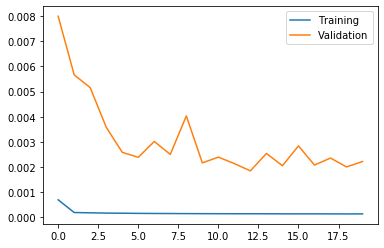

In [32]:
#Initial test with CM data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

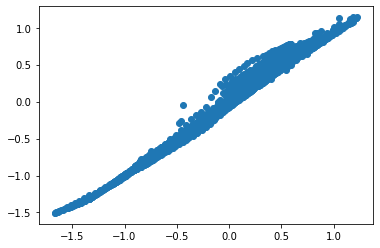

In [19]:
plt.scatter(modelOut['verified'],modelOut['modelPrediction'])

In [20]:
pandasToMat(modelOut, predictFeatures, 'Fill_CapeMay')

Train on 701160 samples, validate on 10588 samples
Epoch 1/20
701160/701160 [==============================] - 14s 20us/step - loss: 4.4871e-04 - mae: 0.0095 - val_loss: 0.0092 - val_mae: 0.0619
Epoch 2/20
701160/701160 [==============================] - 12s 18us/step - loss: 1.6762e-04 - mae: 0.0075 - val_loss: 0.0075 - val_mae: 0.0442
Epoch 3/20
701160/701160 [==============================] - 13s 18us/step - loss: 1.5892e-04 - mae: 0.0071 - val_loss: 0.0071 - val_mae: 0.0477
Epoch 4/20
701160/701160 [==============================] - 13s 18us/step - loss: 1.4780e-04 - mae: 0.0068 - val_loss: 0.0107 - val_mae: 0.0626
Epoch 5/20
701160/701160 [==============================] - 12s 17us/step - loss: 1.4159e-04 - mae: 0.0067 - val_loss: 0.0103 - val_mae: 0.0630
Epoch 6/20
701160/701160 [==============================] - 12s 17us/step - loss: 1.3312e-04 - mae: 0.0064 - val_loss: 0.0125 - val_mae: 0.0668
Epoch 7/20
701160/701160 [==============================] - 12s 17us/step - loss: 1.2

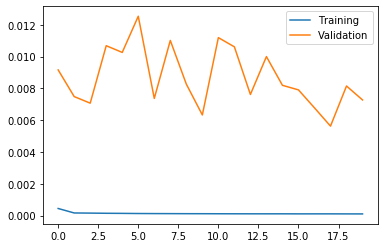

In [9]:
#Testing now with Lewes data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

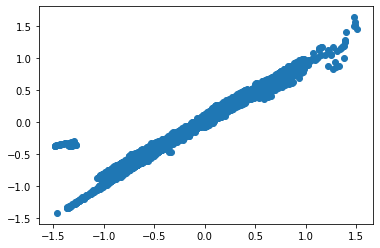

In [10]:
plt.scatter(modelOut['verified'],modelOut['modelPrediction'])

In [11]:
pandasToMat(modelOut, predictFeatures, 'Fill_Lewes')

In [ ]:
#Testing now with AC data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [ ]:
#Testing now with Boston data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

Train on 3495494 samples, validate on 35193 samples
Epoch 1/20
3495494/3495494 [==============================] - 66s 19us/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0211 - val_mae: 0.0942
Epoch 2/20
3495494/3495494 [==============================] - 66s 19us/step - loss: 0.0027 - mae: 0.0267 - val_loss: 0.0211 - val_mae: 0.0915
Epoch 3/20
3495494/3495494 [==============================] - 67s 19us/step - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0187 - val_mae: 0.0912
Epoch 4/20
3495494/3495494 [==============================] - 66s 19us/step - loss: 0.0020 - mae: 0.0212 - val_loss: 0.0125 - val_mae: 0.0693
Epoch 5/20
3495494/3495494 [==============================] - 69s 20us/step - loss: 0.0018 - mae: 0.0198 - val_loss: 0.0126 - val_mae: 0.0725
Epoch 6/20
3495494/3495494 [==============================] - 67s 19us/step - loss: 0.0017 - mae: 0.0189 - val_loss: 0.0120 - val_mae: 0.0685
Epoch 7/20
3495494/3495494 [==============================] - 68s 19us/step - loss: 0.0016 - mae

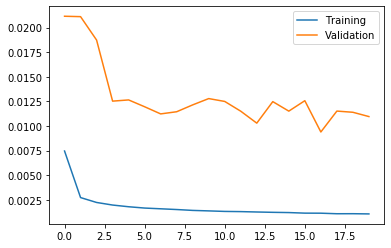

In [65]:
#Initial test with all data - filling gaps (Using all times to train) - with Standard Scaler

epochCount = 20
batchCount = 256
numFeatures = 23
modelOut, model = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, numFeatures)

In [22]:
#This is to prep targets for fitting in scikit-learn
targetTrainIn=np.ravel(targetTrain)
targetTestIn=np.ravel(targetTest)

In [40]:
%%time
# Fitting a linear regression
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(featureTrain, targetTrainIn)

CPU times: user 363 ms, sys: 144 ms, total: 507 ms
Wall time: 223 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
# prediction on the training dataset
mae_train = mean_absolute_error(clf.predict(featureTrain),targetTrain['verified'])
print('mae train = '+ str(mae_train))

# prediction on the testing dataset
mae_test = mean_absolute_error(clf.predict(featureTest),targetTest['verified'])
print('mae test = '+ str(mae_test))

mae train = 0.013709747805967972
mae test = 0.15227738340426844


In [23]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Fitting a Random Forest
clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=10, min_samples_leaf=2)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 5min 1s, sys: 120 ms, total: 5min 1s
Wall time: 38.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [24]:
# prediction on the training dataset
mae_train = mean_absolute_error(clf.predict(featureTrain),targetTrain['verified'])
print('mae train = '+ str(mae_train))

# prediction on the testing dataset
mae_test = mean_absolute_error(clf.predict(featureTest),targetTest['verified'])
print('mae test = '+ str(mae_test))

mae train = 0.010301145862475209
mae test = 0.050540699351446144


In [48]:
%%time
# Fitting a Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 1min 28s, sys: 12.2 ms, total: 1min 28s
Wall time: 1min 28s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [49]:
# prediction on the training dataset
mae_train = mean_absolute_error(clf.predict(featureTrain),targetTrain['verified'])
print('mae train = '+ str(mae_train))

# prediction on the testing dataset
mae_test = mean_absolute_error(clf.predict(featureTest),targetTest['verified'])
print('mae test = '+ str(mae_test))

mae train = 0.01550089753459561
mae test = 0.08633827317570564
